# European Call Option Pricing using Quantum Computers

Qiskit tutorial showing European Call Option Pricing + Spin-echo Optimization

This tutorial follows the methodology described in <a href="https://quantum-journal.org/papers/q-2020-07-06-291/">Option Pricing using Quantum Computers. Stamatopoulos et al. 2019.</a> to price European Call Options on a gate-based quantum computer. 

We use Amplitude Estimation (AE), an algorithm which provides a quadratic speedup compared to classical Monte Carlo methods. We put an emphasis on the implementation of the quantum circuits required to build the input states and operators needed by amplitude estimation to price the European call options.

1. First, we show simulation results to highlight how the circuit that we implement prices the options.

2. Then we simplify the circuit using the spin-echo optimization described in - <a href="https://arxiv.org/abs/2005.07711">Efficient State Preparation for Quantum Amplitude Estimation.
Almudena Carrera Vazquez, Stefan Woerner. 2020.</a>  to reduce the number of gates while keeping the same results (simulation only).

3. Finally, we examine the performance of the option pricing circuits on quantum hardware using the IBM Q Mumbai quantum device. We employ an error mitigation scheme that allows us to significantly reduce the errors arising from noisy two-qubit gates.







## 1. Simulation results

<br>
Suppose a <a href="http://www.theoptionsguide.com/call-option.aspx">European call option</a> with strike price $K$ and an underlying asset whose spot price at maturity $S_T$ follows a given random distribution.
The corresponding payoff function is defined as:

$$f(S_T)=\max\{S_T - K, 0\}$$

We will use a quantum algorithm based on amplitude estimation is used to estimate the expected payoff for the option:

$$\mathbb{E}\left[ \max\{S_T - K, 0\} \right]$$

### Distribution Loading

The first component of our option pricing model is the circuit that takes a probability distribution implied for possible asset prices in the future and loads it into a quantum register such that each basis state represents a possible value and its amplitude the corresponding probability. 

We construct a circuit factory to load a log-normal random distribution into a quantum state.
The distribution is truncated to a given interval $[low, high]$ and discretized using $2^n$ grid points, where $n$ denotes the number of qubits used.
The unitary operator corresponding to the circuit factory implements the following: 

$$\big|0\rangle_{n} \mapsto \big|\psi\rangle_{n} = \sum_{i=0}^{2^n-1} \sqrt{p_i}\big|i\rangle_{n},$$

where $p_i$ denote the probabilities corresponding to the truncated and discretized distribution and where $i$ is mapped to the right interval using the affine map:

$$ \{0, \ldots, 2^n-1\} \ni i \mapsto \frac{high - low}{2^n - 1} * i + low \in [low, high].$$

To examine the behavior of the circuit for different input probability distributions, we run eight experiments that differ by the initial spot price $S_0$ and all other parameters are kept constant. The spot price is varied from $1.8$ to $2.5$ in increments of $0.1$. This way we can use the same circuit for all experiments and only vary the Y-rotation angles used to map the initial probability distribution onto the qubit register. This choice of input parameters allows us to evaluate our circuits for expected option prices in the range $[0.0754,0.7338]$. 

We first compute the probability distribution for each initial spot price. For this tutorial we will do the case $S_0=2$. 

 <font color='green'>Exercise: Choose another initial spot price [1.8, 1.9, 2.1, 2.2, 2.3, 2.4, 2.5] and see how the results change. </font>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution

# number of qubits to represent the uncertainty
num_uncertainty_qubits = 2

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol ** 2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma ** 2 / 2)
variance = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma ** 2, bounds=(low, high))

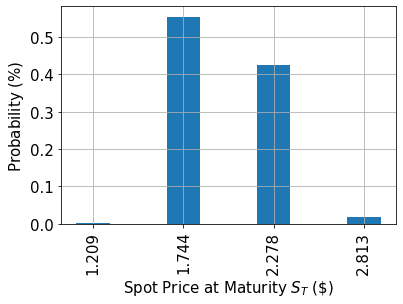

In [2]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

In [3]:
print("For intitial spot price", S, "these are the values and probability distributions:")
for i in 0,1,2,3:
    print("Value", x[i], "Probability", y[i]*100, "%")
   

For intitial spot price 2.0 these are the values and probability distributions:
Value 1.208607238741425 Probability 0.10573576926547217 %
Value 1.743528401859603 Probability 55.432593115910755 %
Value 2.2784495649777803 Probability 42.51986173075732 %
Value 2.813370728095958 Probability 1.9418093840664512 %


### Payoff Function





The payoff function equals zero as long as the spot price at maturity $S_T$ is less than the strike price $K$ and then increases linearly. The implementation uses a comparator, that flips an ancilla qubit from |0⟩ to |1⟩ if $S_T \geqslant K $, and this ancilla is used to control the linear part of the payoff function.

The linear part itself is then approximated as follows. We exploit the fact that $sin^2(y+\pi/4)\approx y + 1/2$ for small |y|. Thus, for a given approximation rescaling factor $c_{approx}$ ∈[0,1] and $x∈[0,1]$ we consider
$$ sin^2(\pi/2*c_{approx}*(x-1/2)+\pi/4)\approx \pi/2*c_{approx}*(x-1/2) + 1/2 $$ 

for small $c_{approx}$.

We can easily construct an operator that acts as 

$$ |x⟩|0⟩ \mapsto |x⟩cos(a*x+b)|0⟩+sin(a*x+b)|1⟩ $$

using controlled Y-rotations.

Eventually, we are interested in the probability of measuring |1⟩ in the last qubit, which corresponds to $sin^2(a*x+b)$. Together with the approximation above, this allows to approximate the values of interest. The smaller we choose $c_{approx}$, the better the approximation. However, since we are then estimating a property scaled by 
$c_{approx}$, the number of evaluation qubits $m$ needs to be adjusted accordingly.

For more details on the approximation, we refer to: - <a href="https://www.nature.com/articles/s41534-019-0130-6">Quantum Risk Analysis. Woerner, Egger. 2018.</a> 



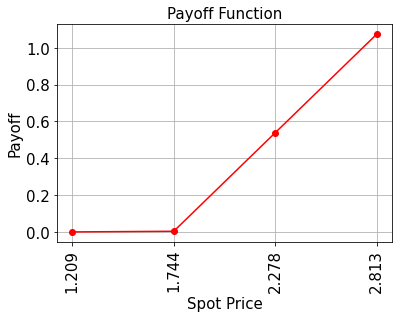

In [4]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price =  1.74

# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [5]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
print("exact expected value:\t%.4f" % exact_value)

exact expected value:	0.2517


### Evaluate Expected Payoff

Qiskit’s finance module offers the EuropeanCallPricing circuit.

In [6]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

# set the approximation scaling for the payoff function
c_approx = 0.25

#dedicated implementation of the estimation problem to the problem applied to european call pricing
european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [7]:
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation, EstimationProblem

# set confidence level
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = MaximumLikelihoodAmplitudeEstimation(evaluation_schedule=[0,1,2,3,4], quantum_instance=qi)
result = ae.estimate(problem)

conf_int=ae.compute_confidence_interval(result, alpha)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.2517
Estimated value:    	0.2583
Confidence interval:	[0.2379, 0.2787]


### Algorithm deep dive

Let's now construct the corresponding circuits to the algorithm.

#### Circuit for $A |0\rangle_3 $  (*k*=0)

The circuit implementing $A$ is constructed in the following way: First we use isometry to load the probability distribution as intial state, and then we use the required gates to evaluate the pay-off function


In [8]:
from qiskit import QuantumCircuit
# Use isometry instruction to set initial state
qc = QuantumCircuit(2)
qc.isometry(np.sqrt(uncertainty_model.probabilities), q_input=[], q_ancillas_for_output=[0,1], q_ancillas_zero=None, q_ancillas_dirty=None)

To encode the payoff function, we apply a uniformly controlled Y-rotation. In this case, this operation can be efficiently implemented using 4 CNOT gates and 4 single-qubit Y-rotations. For optimization purposes, we drop the very last CNOT gate and apply it in a classical postprocessing.

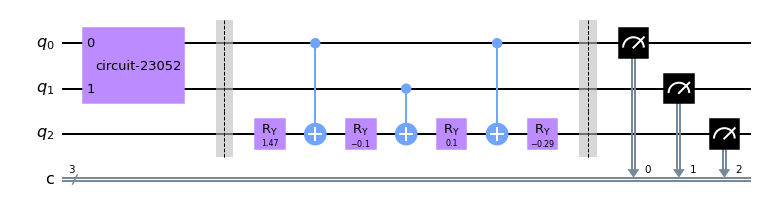

In [9]:
#Let's build the circuit A|0>
circ1 = QuantumCircuit(3,3)
circ1.append(qc, qargs=[0,1])
circ1.barrier()
circ1.ry(1.47,2)
circ1.cx(0,2)
circ1.ry(-0.10,2)
circ1.cx(1,2)
circ1.ry(0.10,2)
circ1.cx(0,2)
circ1.ry(-0.29,2)
#circ1.cx(1,2)
circ1.barrier()
circ1.measure(range(3), range(3))
circ1.draw('mpl')

#### Circuit for $Q A |0\rangle_3 $ (*k*=1) 

We have that $Q=-AS_0A^{\dagger}S_{\psi_0}$, where $S_0=1-2|0\rangle \langle0|$ and $S_{\psi_0}=1-2|\psi_0\rangle|0\rangle \langle\psi_0|\langle0|$. $S_{\psi_0}$ can be implemented up to a global phase using a single-qubit Z-gate on the last qubit (which can be decomposed into a X-rotation and a Y-rotation). $S_0$ is a bit more difficult and we use circuit synthesis for diagonal unitary matrices to achieve an efficient decomposition into gates.

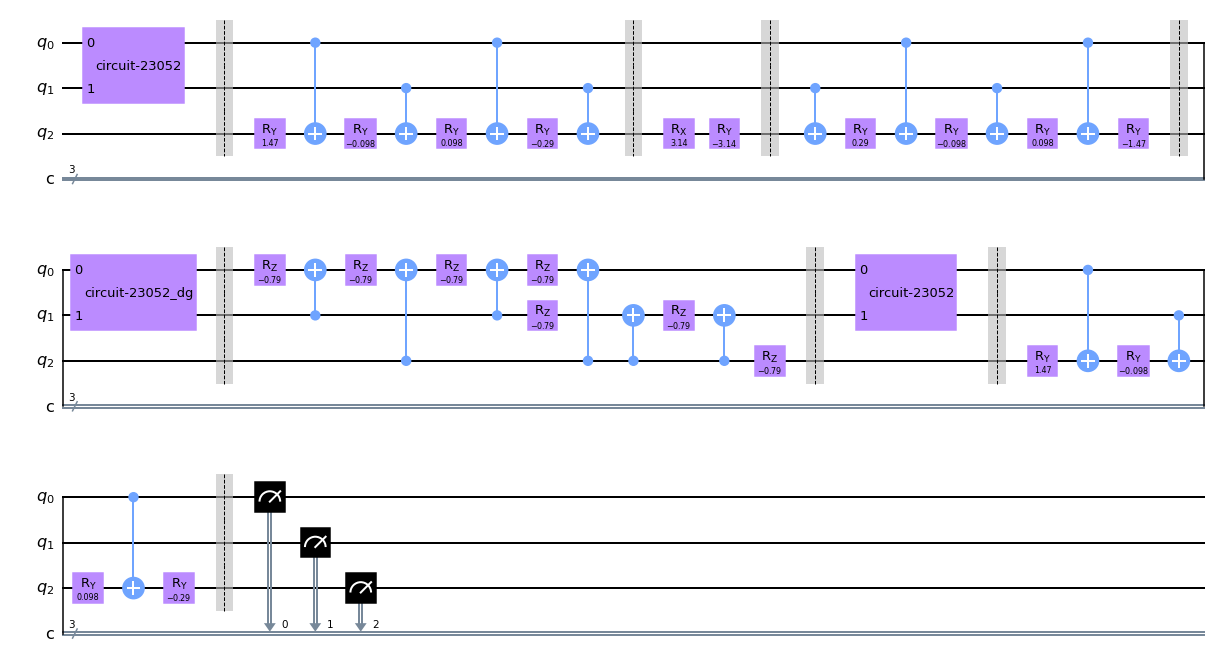

In [10]:
#Let's build the circuit QA|0>
circ2 = QuantumCircuit(3,3)
circ2.append(qc, qargs=[0,1])
circ2.barrier()
circ2.ry(1.47,2)
circ2.cx(0,2)
circ2.ry(-9.8e-2,2)
circ2.cx(1,2)
circ2.ry(9.8e-2,2)
circ2.cx(0,2)
circ2.ry(-0.29,2)
circ2.cx(1,2)
circ2.barrier()
circ2.rx(3.14,2)
circ2.ry(-3.14,2)
circ2.barrier()
circ2.cx(1,2)
circ2.ry(0.29,2)
circ2.cx(0,2)
circ2.ry(-9.8e-2,2)
circ2.cx(1,2)
circ2.ry(9.8e-2,2)
circ2.cx(0,2)
circ2.ry(-1.47,2)
circ2.barrier()
circ2.append(qc.inverse(), qargs=[0,1])
circ2.barrier()
circ2.rz(-0.79,0)
circ2.cx(1,0)
circ2.rz(-0.79,0)
circ2.cx(2,0)
circ2.rz(-0.79,0)
circ2.cx(1,0)
circ2.rz(-0.79,0)
circ2.rz(-0.79,1)
circ2.cx(2,0)
circ2.cx(2,1)
circ2.rz(-0.79,1)
circ2.cx(2,1)
circ2.rz(-0.79,2)
circ2.barrier()
circ2.append(qc, qargs=[0,1])
circ2.barrier()
circ2.ry(1.47,2)
circ2.cx(0,2)
circ2.ry(-9.8e-2,2)
circ2.cx(1,2)
circ2.ry(9.8e-2,2)
circ2.cx(0,2)
circ2.ry(-0.29,2)
#circ2.cx(1,2)
circ2.barrier()
circ2.measure(range(3), range(3))
circ2.draw('mpl')

Now that we have both circuits (k=0 and k=1), we perform repeated measurements of the circuit using qasm_simulator. Each experiment is evaluated on the qasm_simulator with 8192 shots.

In [11]:
from qiskit import transpile

# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

#Transpile circuit for simulator
circ1_trans_sim = transpile(circ1, backend_sim, optimization_level=3)

#Run experiment in the simulator
job_sim1 = backend_sim.run(circ1_trans_sim, shots=8192)
result_sim1 = job_sim1.result()
counts_sim1= result_sim1.get_counts(circ1_trans_sim)
print(counts_sim1)

{'100': 1, '110': 1806, '001': 3131, '111': 51, '011': 113, '101': 1387, '000': 7, '010': 1696}


In [12]:
#Transpile circuit for simulator
circ2_trans_sim = transpile(circ2, backend_sim, optimization_level=3)

#Run experiment in the simulator
job_sim2 = backend_sim.run(circ2_trans_sim, shots=8192)
result_sim2 = job_sim2.result()
counts_sim2= result_sim2.get_counts(circ2_trans_sim)
print(counts_sim2)

{'111': 180, '011': 156, '101': 234, '001': 162, '110': 2235, '000': 5, '010': 5220}


We will use these results later to compute the probability of the objective qubit being $|1 \rangle$ 

## 2. Spin-echo optimization

Now we apply the spin-echo optimization to the circuit $QA|0\rangle$ in the uniformly controlled Y-rotation in A and $A^{\dagger}$


Suppose circuits of the form
$$R_U (θ)V R_U (−θ)$$
where U, V ∈ {X, Y, Z}, i.e., $R_U$ denotes a single-qubit Pauli rotation and V a single-qubit Pauli gate. In case U = V , the gates commute and the circuit equals V . In all other cases, it can easily be seen that
$$ R_U (θ)V R_U (−θ) = R_U (2θ)V$$

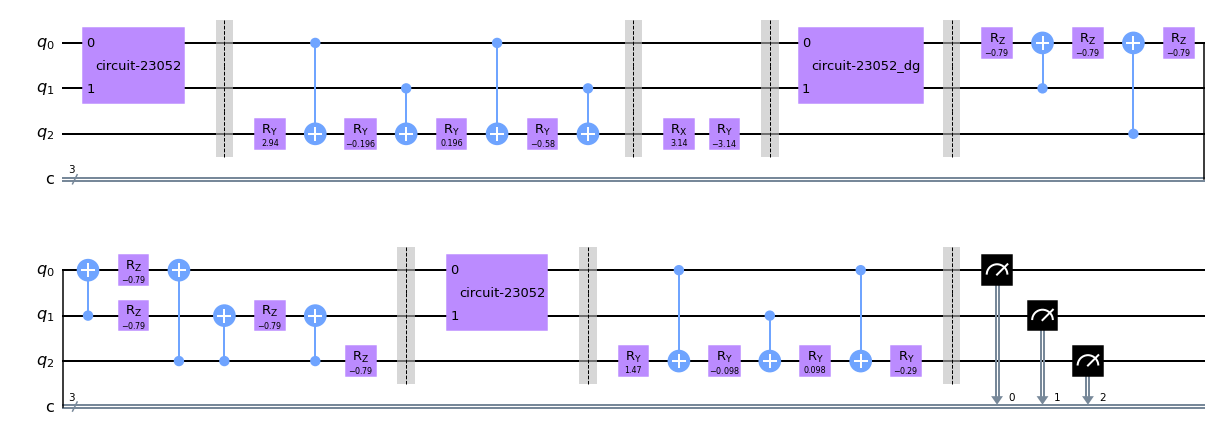

In [13]:
#Optimized circuit
circ3 = QuantumCircuit(3,3)
circ3.append(qc, qargs=[0,1])
circ3.barrier()
circ3.ry(2*1.47,2)
circ3.cx(0,2)
circ3.ry(2*(-9.8e-2),2)
circ3.cx(1,2)
circ3.ry(2*(9.8e-2),2)
circ3.cx(0,2)
circ3.ry(2*(-0.29),2)
circ3.cx(1,2)
circ3.barrier()
circ3.rx(3.14,2)
circ3.ry(-3.14,2)
circ3.barrier()
circ3.append(qc.inverse(), qargs=[0,1])
circ3.barrier()
circ3.rz(-0.79,0)
circ3.cx(1,0)
circ3.rz(-0.79,0)
circ3.cx(2,0)
circ3.rz(-0.79,0)
circ3.cx(1,0)
circ3.rz(-0.79,0)
circ3.rz(-0.79,1)
circ3.cx(2,0)
circ3.cx(2,1)
circ3.rz(-0.79,1)
circ3.cx(2,1)
circ3.rz(-0.79,2)
circ3.barrier()
circ3.append(qc, qargs=[0,1])
circ3.barrier()
circ3.ry(1.47,2)
circ3.cx(0,2)
circ3.ry(-9.8e-2,2)
circ3.cx(1,2)
circ3.ry(9.8e-2,2)
circ3.cx(0,2)
circ3.ry(-0.29,2)
#circ3.cx(1,2)
circ3.barrier()
circ3.measure(range(3), range(3))
circ3.draw('mpl')

In [14]:
#Transpile circuit for simulator
circ3_trans_sim = transpile(circ3, backend_sim, optimization_level=3)

#Run experiment in the simulator
job_sim3 = backend_sim.run(circ3_trans_sim, shots=8192)
result_sim3 = job_sim3.result()
counts_sim3= result_sim3.get_counts(circ3_trans_sim)
print(counts_sim3)

{'111': 180, '011': 184, '101': 222, '000': 7, '010': 5235, '100': 2, '001': 158, '110': 2204}


Again, we will use these results later to compute the probability of the objective qubit being $|1 \rangle$ 

## 3. Quantum Hardware results

We will now examine the performance of the option pricing circuits $A |0\rangle_3 $ and $Q A |0\rangle_3 $ on noisy quantum hardware using the following IBM Q quantum devices:

IBMQ Bogota


We employ an error mitigation scheme that allows us to significantly reduce the errors arising from noisy two-qubit gates. 


The results are affected by readout errors and errors that occur during the execution of the circuits. 

- To mitigate readout errors we run a calibration sequence in which we individually prepare and measure all eight basis states. The result is a 8 x 8 readout-matrix $ R $ that holds the probability of measuring each basis state as function of the basis state in which the system was prepared. We use $ R $ to correct all subsequent measurements. 

- Errors occuring during the quantum circuit can be mitigated using Richardson extrapolation. 
    - First, the quantum circuit is run using a rescaled Hamiltonian to amplify the effect of noise. Second, a Richardson extrapolation is used to extract the result of the quantum circuit at the zero noise limit.
    - Since the single-qubit and CNOT gates have an average randomized benchmarking fidelity of 99.7% and 97.8% respectively, we restrict our error mitigation to the CNOT gates. Furthermore, because the optimized circuit for $A |0\rangle_3 $ contains only 4 CNOT gates, we employ the error mitigation protocol only when evaluating $QA |0\rangle_3 $, which consists of 15 CNOT gates (after spin-echo optimization).
    - We run the circuit for $QA |0\rangle_3 $ 3 times. In each run we replace the CNOT gates of the original circuit by one, three and five CNOT gates (first we have to add the required swap gates to map the circuit to the topology of the backend). Since a pair of perfect CNOT gates simplifies to the identity these extra gates allow us to amplify the error of the CNOT gate without having to stretch the gate duration, thus, avoiding the need to recalibrate the gate parameters. 

First let's explore IBMQ Bogota:

In [ ]:
from qiskit import IBMQ

In [ ]:
IBMQ.save_account('INSERT YOUR TOKEN HERE', overwrite=True)
provider = IBMQ.load_account()

In [ ]:
provider.backends()

In [ ]:
from qiskit.visualization import plot_error_map
backend = provider.get_backend('ibmq_bogota')
plot_error_map(backend)

#### Initial layout
Quantum circuits are abstract entities whose qubits are “virtual” representations of actual qubits used in computations. We need to be able to map these virtual qubits in a one-to-one manner to the “physical” qubits in an actual quantum device. By default, qiskit will do this mapping for you. The choice of mapping depends on the properties of the circuit, the particular device you are targeting, and the optimization level that is chosen.

The choice of initial layout is extremely important when:

Computing the number of SWAP operations needed to map the input circuit onto the device topology.
Taking into account the noise properties of the device.
The choice of initial_layout can mean the difference between getting a result, and getting nothing but noise.

In our experiment we will specify our own initial layout. To do so we can pass a list of integers to qiskit.compiler.transpile() via the initial_layout keyword argument, where the index labels the virtual qubit in the circuit and the corresponding value is the label for the physical qubit to map onto:

After analyzing first the CNOT error rate of every two connected qubits, their readout error rate of each qubit and their physical connectivity we decided to use Qubits 1, 2 and 3. 

<font color='green'>Exercise: Choose another backend and pick the optimal initial layout. </font>

In [ ]:
from qiskit.visualization import plot_circuit_layout
aux_circ1 = transpile(circ1, backend, initial_layout=[2, 1, 3]) 
#virtual qubits [q0, q1, q2] = [2, 1, 3] physical qubits
#q0 virtual qubit with index 0 will be in position 2 of the chip

plot_circuit_layout(aux_circ1, backend)

#### Mapping circuits to hardware topology

In order to implement a CNOT gate between qubits in a quantum circuit that are not directly connected on a quantum device one or more SWAP gates must be inserted into the circuit to move the qubit states around until they are adjacent on the device gate map. Each SWAP gate is decomposed into three CNOT gates on the IBM Quantum devices, and represents an expensive and noisy operation to perform. Thus, finding the minimum number of SWAP gates needed to map a circuit onto a given device, is an important step (if not the most important) in the whole execution process.

However, as with many important things in life, finding the optimal SWAP mapping is hard. In fact it is in a class of problems called NP-Hard, and is thus prohibitively expensive to compute for all but the smallest quantum devices and input circuits. To get around this, by default Qiskit uses a stochastic heuristic algorithm called Qiskit.transpiler.passes.StochasticSwap to compute a good, but not necessarily minimal SWAP count. The use of a stochastic method means the circuits generated by Qiskit.compiler.transpile() (or Qiskit.execute() that calls transpile internally) are not guaranteed to be the same over repeated runs. Indeed, running the same circuit repeatedly will in general result in a distribution of circuit depths and gate counts at the output.

We will use the traspiler and set optimization_level=3 so that the the required SWAP gates are added and optimised.

 <font color='green'>Exercise: For circuit 1 add the SWAP gates manually. Compare your circuit to the transpiled one below </font>

We run the circuit for $QA |0\rangle_3 $ with SWAPS 3 times. In each run we replace the CNOT gates of the original circuit by one, three and five CNOT gates.

In [ ]:
#Transpile circuits for backend
circ1_rh = transpile(circ1, backend, initial_layout=[1, 0, 2], optimization_level=3)
circ2_rh = transpile(circ2, backend, initial_layout=[1, 0, 2], optimization_level=3)
circ3_rh = transpile(circ3, backend, initial_layout=[1, 0, 2], optimization_level=3)

 <font color='green'>Exercise: Build the circuits with 3 and 5 CNOTs </font>
 
 
Note: We need to add barriers in between CNOTs because otherwise the transpiler will cancel them out.

In [ ]:
#Construct circuits with 3 CNOTs and 5 CNOTS 

def create_cx_circuit(qc, num_cx):
    '''
        qc: the quantum circuit
        num_cx: replace each cnot by num_cx cnots
    '''           
    # Create all possible pairs of qubits
    pairs = []
    
    #Add your code here
    
    # Replace the cnots in the qasm file
    qasm_mult_cx = qc.qasm()
    for pair in pairs:
        
        #Add your code here
        
    return QuantumCircuit().from_qasm_str(qasm_mult_cx)

In [ ]:
#Run experiment in the backend (example with circ1_trans_rh)
job_circ1 = backend.run(circ1_rh, shots=8192)
result_circ1 = job_circ1.result()
counts_circ1= result_circ1.get_counts(circ1_rh)

Once we have all the raw hardware results we apply readout error mitigation.

In [ ]:
from qiskit import QuantumRegister
from qiskit.utils.mitigation import complete_meas_cal
# Generate the calibration circuits
qr = QuantumRegister(5)
qubit_list = [1, 0, 2]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [ ]:
# Execute the calibration circuits
job = backend.run(meas_calibs, shots=8192)
cal_results = job.result()

In [ ]:
from qiskit.utils.mitigation import CompleteMeasFitter

# Calculate the calibration matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=[1, 0, 2], circlabel='mcal')

#Apply the calibration to all results
meas_filter = meas_fitter.filter
mitigated_counts_circ1= meas_filter.apply(counts_circ1)

Now that we have all results and they are mitigated we will apply the Richardson extrapolation.

#### Richardson extrapolation with mitigated results 

In [ ]:
# Derive the dictionary without noise. rcs list with the number of shots I obtained for each state with 1, 3 and 5 cnots. 
#It can be considered as a function of the noise, I assume it’s quadratic.
#I do a quadratic fit, I know f(1), f(3) and f(5) I derive f(0) which corresponds to the number of shots if there were no noise.

from scipy.optimize import curve_fit
def fit_quad(y):
    
    p0 = [0.49, 0.2715, -0.91]
    
    x = np.array([1, 3, 5])
    
    f = lambda t, a, b, c: a + b*t +c*t**2
    a = curve_fit(f, x, y, p0, maxfev=10000)
        
    z = [ f(t, *(a[0])) for t in [0, 1, 3, 5]]
    
1    return z

In [ ]:
from itertools import product    
bin_counts = [''.join(p) for p in product('10', repeat=3)] # List of binary strings

for b in bin_counts:  #for each possible state
        rcs = [0.0, 0.0, 0.0] #list which contains only elements
        if b in mitigated_counts_rh3:
            rcs[0] = float(mitigated_counts3[b]) 
        if b in mitigated_counts_rh3_3cnot:
            rcs[1] = float(mitigated_counts3_3cnot[b])
        if b in mitigated_counts_rh3_5cnot:
            rcs[2] = float(mitigated_counts3_5cnot[b])
   
        zq = fit_quad(rcs) # Exponential
        if zq[0] < 0: #for each element in b (the dictionary) the extrapolated value
            zq[0] = 0
        rich[b] = zq[0] #Create dictionary zq[0] corresponds to the extrapolated value for element b
    

#### Expected value of the payoff function

Finally now that we have applied these error mitigations techniques, we can compute the expected value of the payoff function with  the MLE. 

#### Probability that |1> is measured in the objective qubit 𝑞2, (states |001>, |101>, |011> and |111> )

Two possibilities: 

- If we do not drop the last CNOT gate: Then the probability that |1> is measured in the objective qubit 𝑞2 is the probability of states |001>, |011>, |101> and |111>, that is, those that finish in 01 or 11 (in the same order Qiskit shows states). In our experiment {'000' position 0, '001' position 1, '010' position 2, '011' position 3, '100', position 4'101' position 5, '110'position 6 , '111' position 7}


- If we drop the very last CNOT gate of the circuit and apply it in a classical post-processing:

The CNOT gate is two-qubit operation, where the first qubit is usually referred to as the control qubit and the second qubit as the target qubit. Expressed in basis states, the CNOT gate:
* leaves the control qubit unchanged and performs a Pauli-X gate on the target qubit when the control qubit is in state ∣1⟩
* leaves the target qubit unchanged when the control qubit is in state ∣0⟩ 

The CNOT applies to q1 and q2. In our case the second qubit is the control qubit and the third qubit is the target qubit. We just need to see what states result into 01 and 11 when applying a CNOT.

The states we are interested in are therefore those that finish in 01 and 10. (If we apply the CNOT gate to any of those states we end up with states finishing in 01 or 11 as we wanted). Therefore I will measure the probability associated to states |001>, |010>, |110> and |101>.

Taking into account the way Qiskit orders qubits, that is, |q2q1q0> the states |001>, |010>, |110> and |101> are actually |100>, |010>, |011> and |101>



##### List of results
* Simulator, circuit 1
* Simulator, circuit 2
* Simulator, circuit 3 (Spin-echo)
* Raw Real hardware, circuit 1
* Raw Real hardware, circuit 3 (Spin-echo)
* Raw Real hardware, circuit 3 (Spin-echo) with 3 CNOT gates
* Raw Real hardware, circuit 3 (Spin-echo) with 5 CNOT gates
* Mitigated Real hardware, circuit 1
* Mitigated Real hardware, circuit 3 (Spin-echo)
* Mitigated Real hardware, circuit 3 (Spin-echo) with 3 CNOT gates
* Mitigated Real hardware, circuit 3 (Spin-echo) with 5 CNOT gates
* Dictionary after Richardson extrapolation

In [15]:
#Example on how to derive the probability
p1_circ1=(counts_sim1.get("100", 0)+
          counts_sim1.get("010", 0)+
          counts_sim1.get("011", 0)+
          counts_sim1.get("101", 0))/8192
print(p1_circ1)

0.3902587890625


In [16]:
p1_circ2=(counts_sim2.get("100", 0)+
          counts_sim2.get("010", 0)+
          counts_sim2.get("011", 0)+
          counts_sim2.get("101", 0))/8192
print(p1_circ2)

0.684814453125


In [17]:
p1_circ3=(counts_sim3.get("100", 0)
          +counts_sim3.get("010", 0)
          +counts_sim3.get("011", 0)
          +counts_sim3.get("101", 0))/8192
print(p1_circ3)

0.6888427734375


To obtain the estimated value of the payoff function, we use the approximation 

$P_1 \approx  c \frac{2\mathbb{E}\left[ f(X) \right]-f_{min}}{f_{max}-f_{min}}-c+\frac{1}{2}$ 

where $P_1, c, f_{min}$ and $f_{max}$ are know values. 


In [18]:
c=0.25
f_max=1.07
f_min=0
est_value1=((((f_max-f_min)*(p1_circ1+c-0.5))/c)+f_min)/2
est_value3=((((f_max-f_min)*(p1_circ3+c-0.5))/c)+f_min)/2

In [19]:
print(est_value1, est_value3)

0.30015380859375 0.93912353515625


#### Maximum Likelihood Estimator for $\theta_a$:   $\hat{\theta_a}$

We combine the measured probabilities for all *k* (in our example *k=0* and *k*=1) in a single likelihood function, perform a maximum likelihood estimation for $\theta_a$.

We know that $\mathbb{P}[q2=|1>]=\sin^2((2k+1)\theta_a)$. Let $h_i$ be the number of measurements where the objective qubit $q_2$ is $|1\rangle$ for a certain $k_i$. We run the experiment 8192 times. Therefore the likelihood function representing this probabilistic event is given by:

$$L_i(h_i;\theta_a)=[sin^2((2k_i+1)\theta_a)]^{h_i}[cos^2((2k_i+1)\theta_a)]^{8192-h_i}$$



We now have to combine the likelihood functions $L_i(h_i;\theta_a)$ for several ${k_0, ..., k_M}$ (in our example $k_0=0$ and $k_1=1$ to construct a single likelihood function $L(\textbf{h};\theta_a)$:

$$L(\textbf{h};\theta_a)=\prod_{i=0}^{M} L_i(h_i;\theta_a)$$

where $\textbf{h}=(h_0, ..., h_M)$

In our example:

$$L(\textbf{h};\theta_a)= L_0(h_0;\theta_a)L_1(h_1;\theta_a)$$

where $\textbf{h}=(h_0, h_1)$ The ML estimate is defined as the value that maximizes $L(\textbf{h};\theta_a)$:

$$ \hat{\theta_a}=arg_{\theta_a}max L(\textbf{h};\theta_a)= arg_{\theta_a}max lnL(\textbf{h};\theta_a)$$

Now *a* and $\theta_a$ are uniquely related through $a=sin^2(\theta_a)$ in the range $0≤$ $\theta_a$ $≤π/2$, and $\hat{a}=sin^2(\hat{\theta_a})$ is the ML estimate for *a*.

For more details on MLE we refer to - <a href="https://arxiv.org/abs/1904.10246">Amplitude estimation without phase estimation.
Suzuki et al. 2020.</a> 

In our case we have: $k_0=0$ and $k_1=1$

$$L_0(h_0;\theta_a)=[sin^2(\theta_a)]^{h_0}[cos^2(\theta_a)]^{8192-h_0}$$

$$L_1(h_1;\theta_a)=[sin^2(3\theta_a)]^{h_1}[cos^2(3\theta_a)]^{8192-h_1}$$


Therefore:  $$L(\textbf{h};\theta_a)=L_0(h_0;\theta_a)L_1(h_1;\theta_a)=[sin^2(\theta_a)]^{h_0}[cos^2(\theta_a)]^{8192-h_0}[sin^2(3\theta_a)]^{h_1}[cos^2(3\theta_a)]^{8192-h_1}$$

Taking the natural log on both sides we get:

$$lnL(\textbf{h};\theta_a)=2h_{0}ln[sin(\theta_a)]+2(8192-h_0)ln[cos(\theta_a)]+2h_{1}ln[sin(3\theta_a)]+2(8192-h_1)ln[cos(3\theta_a)]$$


Hence: 

$$ \hat{\theta_a}=arg_{\theta_a}max (2h_{0}ln[sin(\theta_a)]+2(8192-h_0)ln[cos(\theta_a)]+2h_{1}ln[sin(3\theta_a)]+2(8192-h_1)ln[cos(3\theta_a)])$$



In order to find $\hat{\theta_a}$ we will use a brute force search, i.e. just discretize with a fine grid and see how it works. We will then plot the likelihood function and check if it is correct. We will use this function from Scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html#scipy.optimize.brute



In [20]:
#Derive h_0 and h_1
h_0=est_value1*8192
h_1=est_value3*8192

#Define the likelihood function f1 as a Python function 
#Note that we will derive the minimum of (-1)*f1 which is the maximum of f1
def f(x):
    value = 0
    value += h_0*np.log((np.sin(x))**2)+(8192-h_0)*np.log(np.cos(x)**2)
    value += h_1*np.log((np.sin(3*x))**2)+(8192-h_1)*np.log(np.cos(3*x)**2)
    return -value

epsilon=1e-10
rranges = [(epsilon, (np.pi/2)-epsilon)]
from scipy import optimize
resbrute = optimize.brute(f, rranges, args=(), Ns=10000, full_output=True, finish=optimize.fmin)

theta_a_est=resbrute[0][0]

Therefore we have obtained the following estimation for the expectation value of the payoff function: 

In [21]:
#We then compute a_est
theta_a_est=resbrute[0][0]
a_est=(np.sin(theta_a_est))**2

In [22]:
print('Estimated value:    \t%.4f' % a_est)
print('Exact value: \t%.4f' % exact_value)

Estimated value:    	0.3226
Exact value: 	0.2517


In [23]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright